# QCoDeS Example with Tektronix AWG5014

## Table of contents

* [Imports and initialisation](#init)
* [Sending waveforms](#sending)
  * [Via an .awg-file](#viaawg)
  * [Sending directly to list](#tolist)
* [Running in "lazy" mode](#lazy)

## Imports and initialisation <a class="anchor" id="init"></a>

In [1]:
%matplotlib nbagg

import os
import time
import logging

import numpy as np
import matplotlib.pyplot as plt

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
import qcodes.instrument_drivers.tektronix.AWG5014 as awg  # <--- The instrument driver
from qcodes.instrument_drivers.tektronix.AWGFileParser import parse_awg_file  # <--- A helper function

awg1 = awg.Tektronix_AWG5014('AWG1', 'TCPIP0::172.20.3.57::inst0::INSTR', timeout=40)

AWG clock freq not set to 1GHz


Connected to: TEKTRONIX AWG5014C (serial:B051039, firmware:SCPI:99.0 FW:4.6.0.7) in 0.10s


In [3]:
# Note: if you have had any initialisation problems, the VISA message queue of the instrument could be fouled up
#(e.g. if the cell above gave you back something like 'Connected to: 1.20000000E+009 ...')
# in that case, run the following command to reset the message queue
awg1.clear_message_queue()

As with any other QCoDeS instrument, parameters can be set and get (gotten).

In [4]:
print(awg1.ch3_state.get())
print(awg1.ch2_offset.get())
awg1.ch2_offset.set(0.1)
print(awg1.ch2_offset.get())

0
0.1
0.1


A list of all available parameters can be found in the following manner:

In [5]:
pars = np.sort(list(awg1.parameters.keys()))
for param in pars:
    print(param, ': ', awg1.parameters[param].label)

DC_output :  DC Output (ON/OFF)
IDN :  IDN
ch1_DC_out :  DC output level channel 1
ch1_add_input :  Add input channel {}
ch1_amp :  Amplitude channel 1 (Vpp)
ch1_direct_output :  Direct output channel 1
ch1_filter :  Low pass filter channel 1
ch1_m1_del :  Channel 1 Marker 1 delay (ns)
ch1_m1_high :  Channel 1 Marker 1 high level (V)
ch1_m1_low :  Channel 1 Marker 1 low level (V)
ch1_m2_del :  Channel 1 Marker 2 delay (ns)
ch1_m2_high :  Channel 1 Marker 2 high level (V)
ch1_m2_low :  Channel 1 Marker 2 low level (V)
ch1_offset :  Offset channel 1 (V)
ch1_state :  Status channel 1
ch1_waveform :  Waveform channel 1
ch2_DC_out :  DC output level channel 2
ch2_add_input :  Add input channel {}
ch2_amp :  Amplitude channel 2 (Vpp)
ch2_direct_output :  Direct output channel 2
ch2_filter :  Low pass filter channel 2
ch2_m1_del :  Channel 2 Marker 1 delay (ns)
ch2_m1_high :  Channel 2 Marker 1 high level (V)
ch2_m1_low :  Channel 2 Marker 1 low level (V)
ch2_m2_del :  Channel 2 Marker 2 dela

## SENDING WAVEFORMS <a class="anchor" id="sending"></a>

There are two supported ways of sending waveforms to the AWG; by making an .awg file, sending and loading that, or by sending waveforms to the User Defined list one by one and putting them in the sequencer. The first method is generally faster.

### MAKING SOME WAVEFORMS

First, we make a handful of pulse shapes and marker signals to send to the AWG. This should be done with numpy arrays.

Please note that the waveforms must **not** have values exceeding -1 to 1, and that the markers must **only** have values 0 or 1. Otherwise the AWG misinterprets the signals.

In this example, we only use two channels of the AWG, namely channel 1 and 3. Extending to one or more should be straightforward.

In [6]:
noofseqelems = 6
noofpoints = 1200
waveforms = [[], []]  # one list for each channel
m1s = [[], []]
m2s = [[], []]
for ii in range(noofseqelems):
    # waveform and markers for channel 1
    waveforms[0].append(np.sin(np.pi*(ii+1)*np.linspace(0, 1, noofpoints))*np.hanning(noofpoints))
    m1 = np.zeros(noofpoints)
    m1[:int(noofpoints/(ii+1))] = 1
    m1s[0].append(m1)
    m2 = np.zeros(noofpoints)
    m2s[0].append(m2)
    
    # waveform and markers for channel two
    wf = np.sin(np.pi*(ii+1)*np.linspace(0, 1, noofpoints))
    wf *= np.arctan(np.linspace(-20, 20, noofpoints))/np.pi*2
    waveforms[1].append(wf)
    m1 = np.zeros(noofpoints)
    m1[:int(noofpoints/(ii+1))] = 1
    m1s[1].append(m1)
    m2 = np.zeros(noofpoints)
    m2s[1].append(m2)

<IPython.core.display.Javascript object>


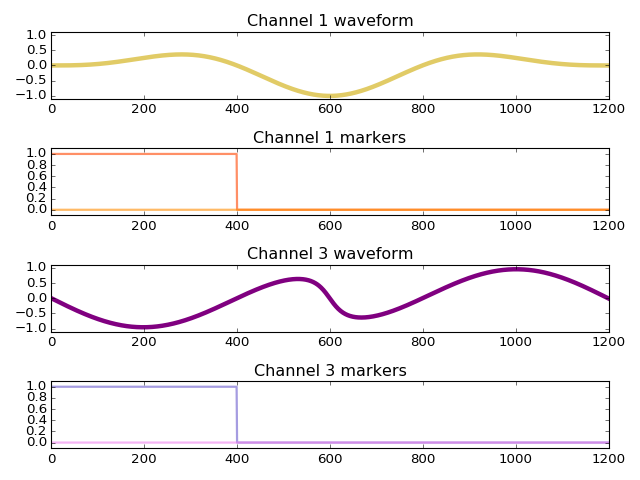

In [7]:
# We can visualise the waveforms and markers
fig = plt.figure()

ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)
ax1.set_title('Channel 1 waveform')
ax1.set_ylim([-1.1, 1.1])
ax2.set_title('Channel 1 markers')
ax2.set_ylim([-0.1, 1.1])
ax3.set_title('Channel 3 waveform')
ax3.set_ylim([-1.1, 1.1])
ax4.set_title('Channel 3 markers')
ax4.set_ylim([-0.1, 1.1])

elemnum = 2  # choose which element to plot
ax1.plot(waveforms[0][elemnum], lw=4, color='#e1cb66')
ax2.plot(m1s[0][elemnum], lw=2, color='#FF4500', alpha=0.6)
ax2.plot(m2s[0][elemnum], lw=2, color='#FF8C00', alpha=0.6)
ax3.plot(waveforms[1][elemnum], lw=4, color='#800080')
ax4.plot(m1s[1][elemnum], lw=2, color='#6A5ACD', alpha=0.6)
ax4.plot(m2s[1][elemnum], lw=2, color='#EE82EE', alpha=0.6)

plt.tight_layout()

### GETTING THEM THERE VIA AN .AWG FILE <a class="anchor" id="viaawg"></a>

The fastest way to transfer waveforms to the AWG is by using an .awg file. 

In addition to waveforms and markers, me must specify sequencing options for each sequence element.

In this example notebook, we just put in some random numbers.

In [37]:
# Sequencing options

# number of repetitions
nreps = [2 for ii in range(noofseqelems)]
# Wait trigger (0 or 1)
trig_waits = [0]*noofseqelems
# Goto state
goto_states = [((ii+1) % noofseqelems)+1 for ii in range(noofseqelems)]
#goto_states = [0]*noofseqelems
# Event jump
jump_tos = [2]*noofseqelems

Then all the magic happens in the following function call (type help(make_send_and_load_awg_file) to see all possible input parameters):

In [38]:
awg1.make_send_and_load_awg_file(waveforms, m1s, m2s, 
                                 nreps, trig_waits,
                                 goto_states, jump_tos, channels=[1, 3])

In order to build a local library of pulse sequences, one may generate and locally save the .awg file.

In [10]:
filepath = os.path.join(os.getcwd(), 'test_awg_file.awg')
awgfile = awg1.make_and_save_awg_file(waveforms, m1s, m2s, nreps, trig_waits, goto_states,
                                      jump_tos, channels=[1, 3], filename=filepath)

A saved .awg file may be loaded back into memrory using the helper function `parse_awg_file`,
which returns a tuple containing:
* A tuple matching the call signature of `awg1.make_and_save_awg_file` (see below)
* A dictionary with all the instrument settings of the .awg file

In [11]:
(callsig, instdict) = parse_awg_file(filepath)
(waveforms, m1s, m2s, nreps, trig_waits, goto_states, jump_tos, channels) = callsig

To see how everything fits together, we may now upload the file we just parsed.

In [12]:
awg1.make_send_and_load_awg_file(waveforms, m1s, m2s, 
                                 nreps, trig_waits,
                                 goto_states, jump_tos, channels=channels)

### GETTING THEM THERE BY SENDING WAVEFORMS TO LIST <a class="anchor" id="tolist"></a>

An alternative way to transfer waveforms to the AWG is by sending them directly to the waveform list and then putting them into the sequencer. This method is more explicit, but slower for large waveforms.

In [13]:
# First clear up the waveform list and empty the sequencer
awg1.delete_all_waveforms_from_list()
# Then set the sequence length to the correct number lest not all sequence elements get uploaded
awg1.sequence_length.set(noofseqelems)

In [14]:
#Then transfer the waveforms to the list...
for elnum in range(noofseqelems):
    for chnum in range(2):
        wfmname = 'wfm{:03d}ch{}'.format(elnum, chnum+1)
        awg1.send_waveform_to_list(waveforms[chnum][elnum], m1s[chnum][elnum], m2s[chnum][elnum], wfmname)
#...upload them to the sequencer...
for elnum in range(noofseqelems):
    for chnum in range(2):
        wfmname = 'wfm{:03d}ch{}'.format(elnum, chnum+1)
        awg1.set_sqel_waveform(wfmname, chnum+1, elnum+1)
#...and set the sequence elements setting
for elnum in range(noofseqelems):
    awg1.set_sqel_goto_target_index(elnum+1, goto_states[elnum])
    awg1.set_sqel_loopcnt(nreps[elnum], elnum+1)
    awg1.set_sqel_trigger_wait(elnum+1, trig_waits[elnum])
    awg1.set_sqel_event_target_index(elnum+1, jump_tos[elnum])

## Running the AWG in "lazy" mode <a class="anchor" id="lazy"></a>

In "lazy" mode, the AWG continuously outputs a specific sequence element until the user forces a jump to another element (as opposed to running through the sequence in a particular predefined order). On the hardware side, this is still done by running the AWG in `sequence` mode, but with all sequence elements having their sequencer options set to infinite repetitions.

Below we assume that the above awg file has been loaded into the sequencer.

The parameter controlling the sequence element currently being run is called `sequence_pos`. Note that this is also accesible in non-lazy mode, although in that mode its return value quickly becomes obsolete.

In [25]:
from time import sleep

# Set the corresponding sequencing options
for seq_elem in range(1, awg1.sequence_length.get()+1):
    awg1.set_sqel_loopcnt_to_inf(seq_elem, state=1)

In [42]:
# Now jump around in a "lazy" way
awg1.run()
awg1.sequence_pos.set(1)
sleep(2)
awg1.sequence_pos.set(3)
sleep(1)
awg1.sequence_pos.set(2)
sleep(3)
awg1.stop()

For completeness, we note that infinite repetitions of each sequence element can be achieved by setting the number of repetitions to 0 when casting the awg file.

In [40]:
# number of repetitions
nreps = [0 for ii in range(noofseqelems)]  # Infinite repetitions

# It doesn't matter what we set the next values to, but the lists need to exist and have the right length

# Wait trigger (0 or 1)
trig_waits = [0]*noofseqelems
# Goto state
goto_states = [0]*noofseqelems
# Event jump
jump_tos = [0]*noofseqelems

awg1.make_send_and_load_awg_file(waveforms, m1s, m2s, 
                                 nreps, trig_waits,
                                 goto_states, jump_tos, channels=[1, 3])

Finally, close down the instrument.

In [17]:
awg1.close()

In [43]:
awg1.IDN()

{'firmware': 'SCPI:99.0 FW:4.6.0.7',
 'model': 'AWG5014C',
 'serial': 'B051039',
 'vendor': 'TEKTRONIX'}

In [44]:
awg1.send_DC_pulse(2, 0.1, 5)

AttributeError: 'Tektronix_AWG5014' object and its delegates have no attribute 'chandcs'